In [56]:
import pandas as pd
import psycopg2
import pandas.io.sql as psql
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier
from scipy.sparse import hstack
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.manifold import TSNE
%matplotlib inline

# Carga de datos

In [2]:
usecols = [
    "id",
    "place_name",
    "place_country",
    "latitude",
    "longitude"
]

In [3]:
total_users = pd.read_pickle("../../../../dosT/ffunes/total_users_parsed.pkl")

In [4]:
total_users = total_users.loc[:, usecols]

In [5]:
total_users.shape

(176029, 5)

In [6]:
usecols = [
    "user_id",
    "hashtags",
    "mentions_country"
]

In [7]:
users_with_hashtags = pd.read_pickle("../../../../dosT/ffunes/users_with_hashtags.pkl")

In [8]:
users_with_hashtags = users_with_hashtags.loc[:, usecols]

In [9]:
users_with_hashtags.shape

(65206, 3)

In [10]:
usecols = [
    "user_id",
    "users_mentioned"
]

In [11]:
users_with_mentions = pd.read_pickle("../../../../dosT/ffunes/users_with_mentions.pkl")

In [12]:
users_with_mentions = users_with_mentions.loc[:, usecols]

In [13]:
users_with_mentions.shape

(96512, 2)

In [14]:
total_users = pd.merge(
    left=total_users,
    right=users_with_hashtags,
    how='left',
    left_on='id',
    right_on='user_id',
    validate='1:1'
)
del total_users['user_id']

In [15]:
total_users = pd.merge(
    left=total_users,
    right=users_with_mentions,
    how='left',
    left_on='id',
    right_on='user_id',
    validate='1:1'
)
del total_users['user_id']

Veamos que % de usuarios tienen hashtags o menciones

In [16]:
total_users.dropna(subset=["users_mentioned", "hashtags"], how='all').shape[0]

114759

In [17]:
total_users.dropna(subset=["users_mentioned", "hashtags"], how='all').shape[0]/total_users.shape[0]

0.6519323520556272

In [18]:
users_train = total_users.dropna(subset=["users_mentioned", "hashtags"], how='all')

In [19]:
users_train.shape

(114759, 8)

In [20]:
users_train.loc[:, ['hashtags']] = users_train['hashtags'].apply(lambda x: x if isinstance(x, list) else [])
users_train.loc[:, ['mentions_country']] = users_train['mentions_country'].apply(lambda x: x if isinstance(x, list) else [])
users_train.loc[:, ['users_mentioned']] = users_train['users_mentioned'].apply(lambda x: x if isinstance(x, list) else [])

/var/home/ffunes/venv/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [21]:
users_train.loc[:, ['users_mentioned']] = users_train["users_mentioned"].apply(lambda l: list(map(str, l)))

In [22]:
users_train["unified_place"] = users_train["place_name"] + ',' + users_train["place_country"]

/var/home/ffunes/venv/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


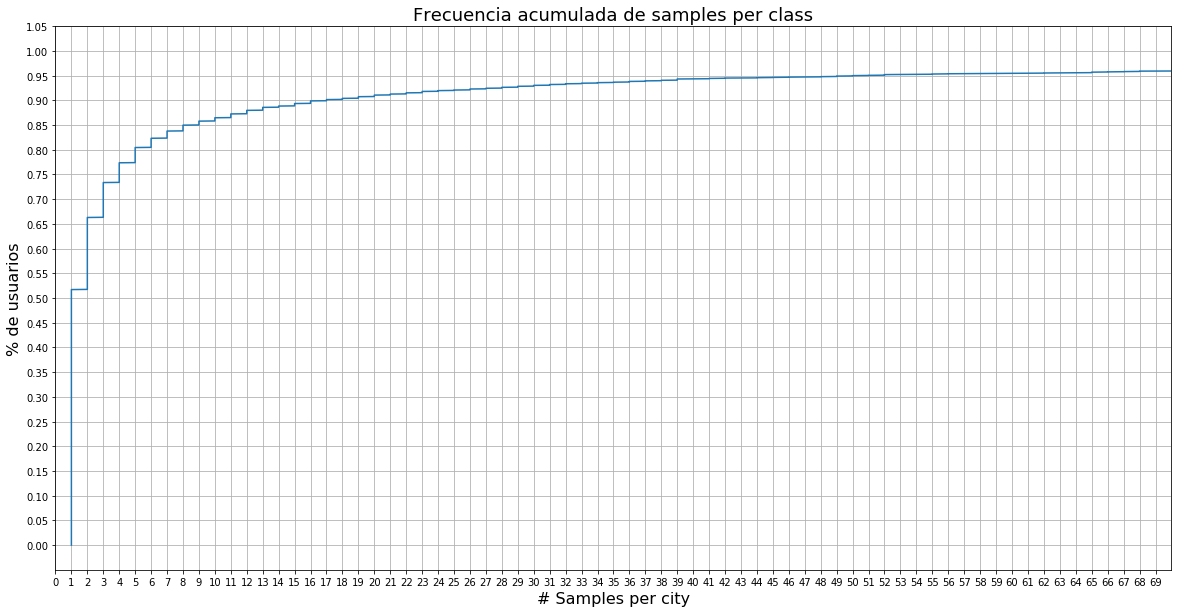

In [23]:
ecdf = ECDF(users_train['unified_place'].value_counts())

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("# Samples per city", fontsize=16)
plt.ylabel("% de usuarios", fontsize=16)
plt.title("Frecuencia acumulada de samples per class", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.05))
plt.xticks(np.arange(0,70,1))
plt.xlim(0, 70)
#plt.hlines(accuracy_score(y_test[:, 0], y_predicted_city), -200, 1000, colors='r', linestyles='dashed')
#plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

In [24]:
min_determined_place = users_train.loc[:, ["id", "unified_place"]].groupby("unified_place").count().sort_values('id', ascending=False).reset_index()

In [25]:
min_determined_place.head(5)

,unified_place,id
0,"ciudad autónoma de buenos aires,argentina",20581
1,"córdoba,argentina",4841
2,"rosario,argentina",3831
3,"la plata,argentina",2786
4,"mar del plata,argentina",1978


In [26]:
min_determined_place["id"].median()

1.0

In [27]:
min_determined_place.shape

(5279, 2)

# Mínimo de muestras por clase para entrenar

In [28]:
min_determined_place = min_determined_place.loc[min_determined_place["id"] >= 799, :]

In [29]:
min_determined_place.shape

(23, 2)

In [30]:
users_train_selected = pd.merge(
    left=users_train,
    right=min_determined_place.loc[:, ['unified_place']],
    how='inner',
    left_on='unified_place',
    right_on='unified_place',
    validate='m:1'
)
users_train_selected.shape

(54099, 9)

In [31]:
class_names = sorted(users_train_selected['unified_place'].unique())

In [32]:
users_complete_location = users_train_selected.loc[:, ["unified_place", "latitude", "longitude"]].values

# Función para mostrar árboles

In [33]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import graphviz 

def show_tree(estimator, feature_names, class_names):
    dot_data = StringIO()

    export_graphviz(estimator, 
                    out_file=dot_data,
                    feature_names = feature_names,
                    class_names = class_names,
                    filled=True,
                    rounded=True,
                    special_characters=True)

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png())

/var/home/ffunes/venv/lib/python3.5/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


# Función para calcular distancias entre datos predecidos y reales

In [34]:
geonames = pd.read_pickle("../../../../dosT/ffunes/geonames_parsed.pkl")

from math import radians, sin, cos, atan2, sqrt

def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6371 # km

    dlat = radians(lat2-lat1)
    dlon = radians(lon2-lon1)
    a = sin(dlat/2) * sin(dlat/2) + cos(radians(lat1)) \
        * cos(radians(lat2)) * sin(dlon/2) * sin(dlon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = radius * c

    return d

def determine_distance(row):
    predicted_lat = row['predicted_lat']
    predicted_lon = row['predicted_lon']
    real_lat = row['real_lat']
    real_long = row['real_lon']
    
    return haversine_distance(predicted_lat, predicted_lon, real_lat, real_long)

def get_difference_distance(predicted_place, real_place):
    df_prediction = pd.DataFrame({
        'predicted_place': predicted_place,
        'real_place': real_place
    }, dtype=float)
        
    df_prediction[['predicted_cities','predicted_countries']] = df_prediction.predicted_place.str.split(',', expand=True) 
    df_prediction[['real_cities','real_countries']] = df_prediction.real_place.str.split(',', expand=True) 
    
    del df_prediction['predicted_place']
    del df_prediction['real_place']
    
    df_prediction = pd.merge(
        left=df_prediction,
        right=geonames.loc[:,['alternatenames', 'country', 'latitude', 'longitude']],
        how='left',
        left_on=['predicted_cities', 'predicted_countries'],
        right_on=['alternatenames', 'country'],
        validate='m:1'
    )
    
    df_prediction.rename(columns={'latitude': 'predicted_lat', 'longitude': 'predicted_lon'}, inplace=True)
    
    del df_prediction['alternatenames']
    del df_prediction['country']
    
    df_prediction = pd.merge(
        left=df_prediction,
        right=geonames.loc[:,['alternatenames', 'country', 'latitude', 'longitude']],
        how='left',
        left_on=['real_cities', 'real_countries'],
        right_on=['alternatenames', 'country'],
        validate='m:1'
    )
    
    del df_prediction['alternatenames']
    del df_prediction['country']
    
    df_prediction.rename(columns={'latitude': 'real_lat', 'longitude': 'real_lon'}, inplace=True)
    
    #print(df_prediction.head(5))
    
    print("Total NaN: ", df_prediction.shape[0]-df_prediction.dropna(subset=['real_lat', 'real_lon', 'predicted_lat', 'predicted_lon']).shape[0])

    return df_prediction.apply(determine_distance, axis=1)

# Hashtags y menciones - sin generar muestras

In [35]:
vectorizer = CountVectorizer(
    strip_accents="ascii",
    lowercase=True,
)

vector_of_hashtags = vectorizer.fit_transform(users_train_selected["hashtags"].apply(lambda x: ' '.join(x))).astype('bool')
vector_of_hashtags

<54099x4786 sparse matrix of type '<class 'numpy.bool_'>'
	with 231216 stored elements in Compressed Sparse Row format>

In [36]:
hashtag_list = vectorizer.get_feature_names()

In [37]:
vectorizer = CountVectorizer(
    strip_accents="ascii",
    lowercase=True,
)

vector_of_hashtags_countries = vectorizer.fit_transform(users_train_selected["mentions_country"].apply(lambda x: ' '.join(x))).astype('bool')
vector_of_hashtags_countries

<54099x15 sparse matrix of type '<class 'numpy.bool_'>'
	with 1191 stored elements in Compressed Sparse Row format>

In [38]:
mentioned_places = vectorizer.get_feature_names()

In [39]:
vectorizer = CountVectorizer(
    strip_accents="ascii",
    lowercase=True,
)

vector_of_mentions = vectorizer.fit_transform(users_train_selected["users_mentioned"].apply(lambda x: ' '.join(x))).astype('bool')
vector_of_mentions

<54099x93443 sparse matrix of type '<class 'numpy.bool_'>'
	with 795381 stored elements in Compressed Sparse Row format>

Generamos el grafo para procesar node2vec y reducir dimensiones de las menciones

In [40]:
cx = vector_of_mentions.tocoo()
edges = []
for i,j,v in zip(cx.row, cx.col, cx.data):
    format_str = str(i) + " " + str(j)
    edges.append(format_str)

In [41]:
len(edges)

795381

In [42]:
df = pd.DataFrame({"edges": edges})
df.to_csv("../edges_mentions.csv", header=False, index=False)

In [54]:
!cd ../snap/examples/node2vec && \
./node2vec -i:../../../edges_mentions.csv -o:../../../edges_mentions_node2vec.emb -d:16 -p:0.25 -q:0.25 -l:3 -r:10


An algorithmic framework for representational learning on graphs. [Apr 21 2020]
Input graph path (-i:)=../../../edges_mentions.csv
Output graph path (-o:)=../../../edges_mentions_node2vec.emb
Number of dimensions. Default is 128 (-d:)=16
Length of walk per source. Default is 80 (-l:)=3
Number of walks per source. Default is 10 (-r:)=10
Context size for optimization. Default is 10 (-k:)=10
Number of epochs in SGD. Default is 1 (-e:)=1
Return hyperparameter. Default is 1 (-p:)=0.25
Inout hyperparameter. Default is 1 (-q:)=0.25
Verbose output. (-v)=NO
Graph is directed. (-dr)=NO
Graph is weighted. (-w)=NO
Output random walks instead of embeddings. (-ow)=NO


In [47]:
vector_of_mentions_node2vec = pd.read_csv("../edges_mentions_node2vec.emb", header=None, skiprows=1, sep=" ")
vector_of_mentions_node2vec.drop(range(vector_of_mentions.shape[0], vector_of_mentions.shape[1]), inplace=True)
vector_of_mentions_node2vec.drop(0, axis=1, inplace=True)
vector_of_mentions_node2vec.shape

(54099, 128)

In [129]:
#mentions_list = vectorizer.get_feature_names()

In [130]:
#feature_names = hashtag_list + mentioned_places + mentions_list

# Menciones con Node2vec

In [41]:
vector = hstack([vector_of_hashtags, vector_of_hashtags_countries, vector_of_mentions_node2vec.values])

In [42]:
X_train, X_test, y_train, y_test = train_test_split(vector, users_complete_location[:,0], test_size=0.30)

DecisionTree

In [43]:
decisiontree = DecisionTreeClassifier()
decisiontree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [44]:
param_grid= {'max_features': [10, 20, 50, 'auto', 1000, 2000,None], 'max_depth': [8, 80, 200, 500, None], 'min_samples_leaf': [1],
             'class_weight': ['balanced']}#, 'min_samples_split': [2500]}
grid_drop = GridSearchCV(decisiontree, param_grid, cv=5, scoring='accuracy')
grid_drop.fit(X_train, y_train)
print(grid_drop.best_params_, grid_drop.best_score_)

{'class_weight': 'balanced', 'max_depth': None, 'max_features': 2000, 'min_samples_leaf': 1} 0.24352375022363965


In [45]:
y_predicted = grid_drop.predict(X_test)

In [46]:
accuracy_score(y_test, y_predicted)

0.24306839186691312

In [47]:
balanced_accuracy_score(y_test, y_predicted)

0.1612838700339773

In [48]:
distances_predicted = get_difference_distance(
    y_predicted,
    y_test
)

Total NaN:  0


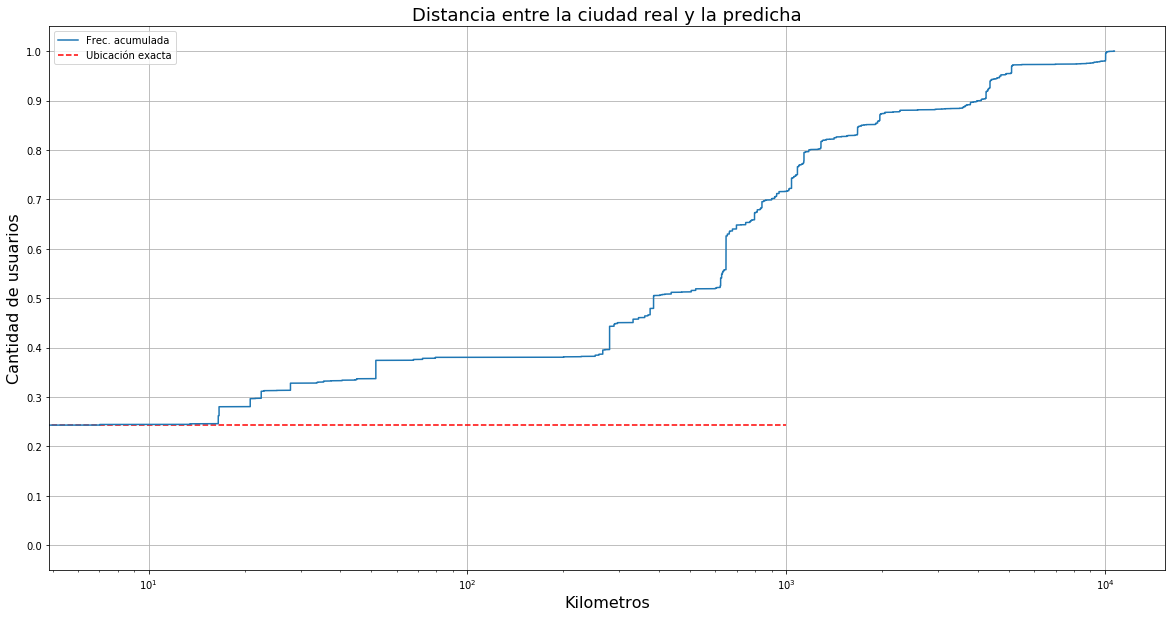

In [49]:
ecdf = ECDF(distances_predicted)

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("Kilometros", fontsize=16)
plt.ylabel("Cantidad de usuarios", fontsize=16)
plt.title("Distancia entre la ciudad real y la predicha", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.1))
#plt.x
#plt.xticks(np.arange(0,1000,50))
plt.xscale('log')
plt.hlines(accuracy_score(y_test, y_predicted), -200, 1000, colors='r', linestyles='dashed')
plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

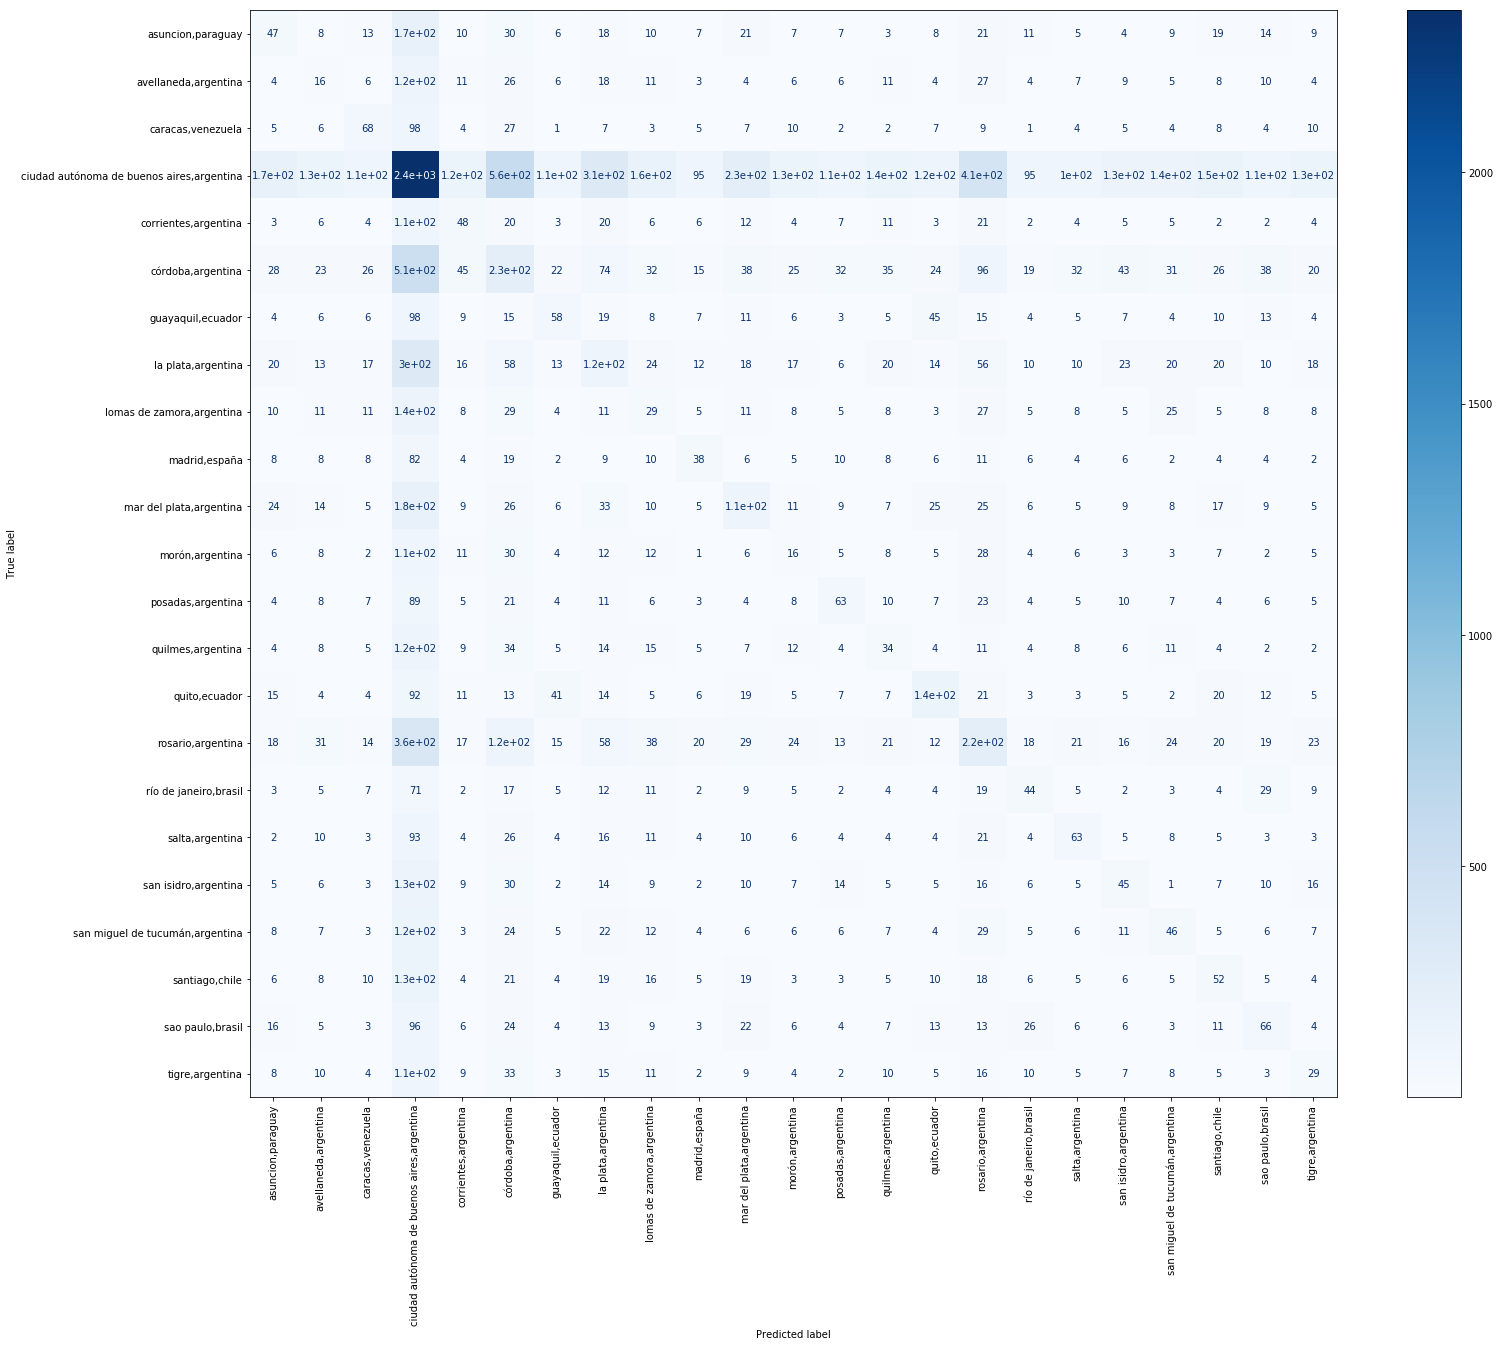

In [50]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 20)
disp = plot_confusion_matrix(grid_drop.best_estimator_, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None,
                                xticks_rotation='vertical',
                            ax=ax)

SVM

In [43]:
X_train_scaled = scale(X_train, with_mean=False)
X_test_scaled = scale(X_test, with_mean=False)

In [44]:
svc = SVC()

param_grid= {'class_weight': ['balanced'], 'cache_size': [2000.0]}

grid_drop = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
grid_drop.fit(X_train_scaled, y_train)
print(grid_drop.best_params_, grid_drop.best_score_)

{'cache_size': 2000.0, 'class_weight': 'balanced'} 0.1924003670845562


In [45]:
y_predicted = grid_drop.predict(X_test_scaled)

In [46]:
accuracy_score(y_test, y_predicted)

0.1935304990757856

In [47]:
balanced_accuracy_score(y_test, y_predicted)

0.16711896199417342

In [48]:
distances_predicted = get_difference_distance(
    y_predicted,
    y_test
)

Total NaN:  0


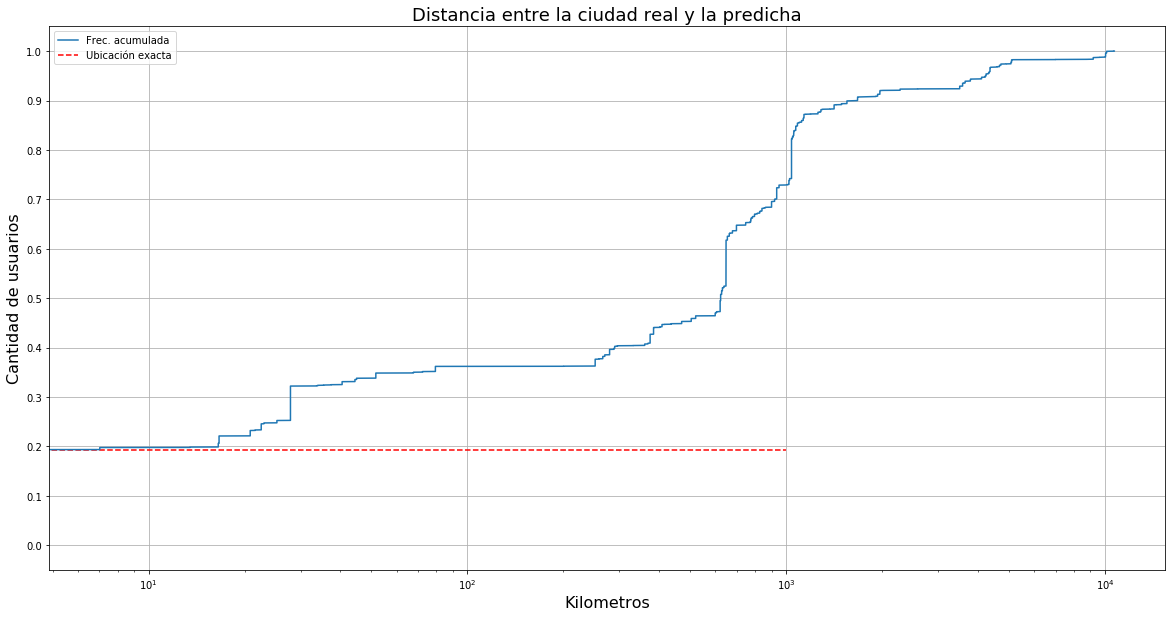

In [49]:
ecdf = ECDF(distances_predicted)

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("Kilometros", fontsize=16)
plt.ylabel("Cantidad de usuarios", fontsize=16)
plt.title("Distancia entre la ciudad real y la predicha", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.1))
#plt.x
#plt.xticks(np.arange(0,1000,50))
plt.xscale('log')
plt.hlines(accuracy_score(y_test, y_predicted), -200, 1000, colors='r', linestyles='dashed')
plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

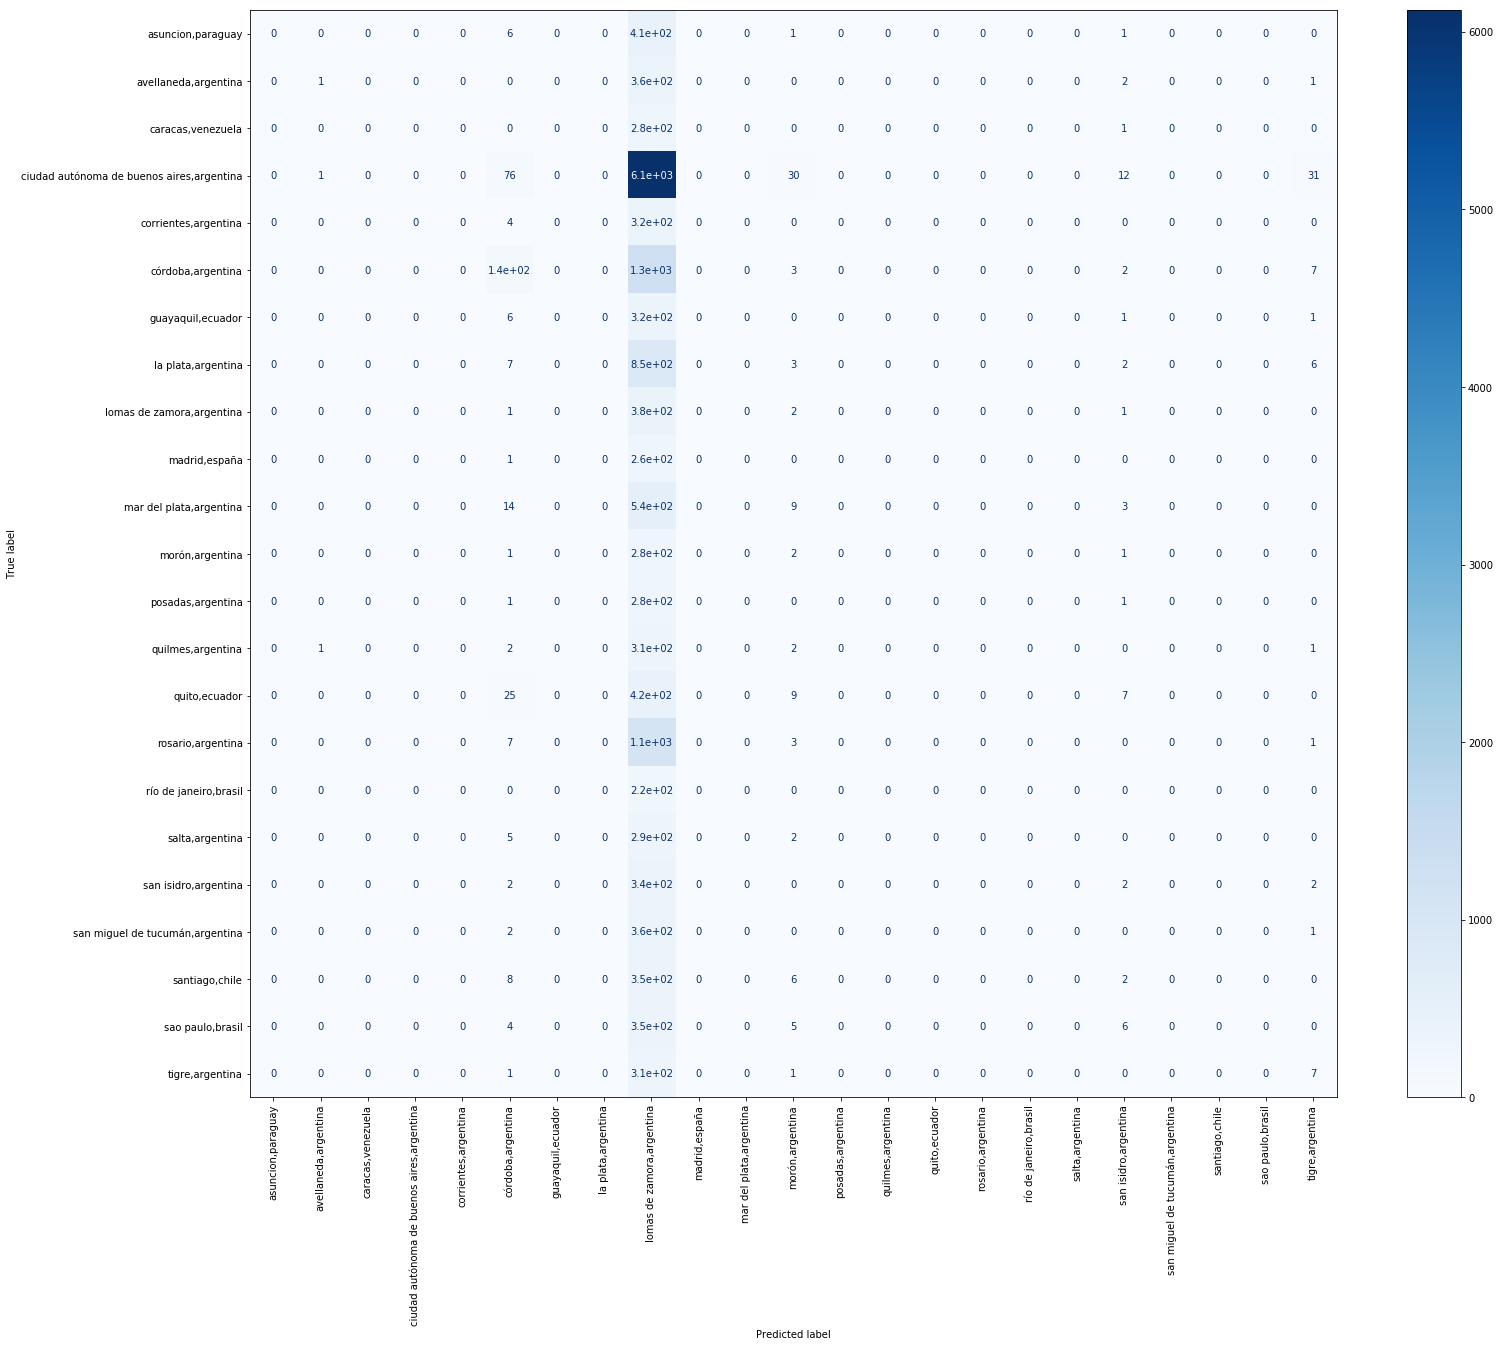

In [50]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 20)
disp = plot_confusion_matrix(grid_drop.best_estimator_, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None,
                                xticks_rotation='vertical',
                            ax=ax)

# Menciones con Node2vec y pesos en aristas

In [51]:
vectorizer = CountVectorizer(
    strip_accents="ascii",
    lowercase=True,
)

vector_of_mentions = vectorizer.fit_transform(users_train_selected["users_mentioned"].apply(lambda x: ' '.join(x)))
vector_of_mentions

<54099x93443 sparse matrix of type '<class 'numpy.int64'>'
	with 795381 stored elements in Compressed Sparse Row format>

Generamos el grafo para procesar node2vec y reducir dimensiones de las menciones

In [52]:
cx = vector_of_mentions.tocoo()
edges = []
for i,j,v in zip(cx.row, cx.col, cx.data):
    format_str = str(i) + " " + str(j) + " " + str(v)
    edges.append(format_str)

In [53]:
df = pd.DataFrame({"edges": edges})
df.to_csv("../edges_mentions_weighted.csv", header=False, index=False)

In [54]:
!cd ../snap/examples/node2vec && \
./node2vec -i:../../../edges_mentions_weighted.csv -o:../../../edges_mentions_weighted_node2vec.emb -d:128 -p:0.25 -q:0.25 -l:110 -r:20 -dr -w


An algorithmic framework for representational learning on graphs. [Apr 21 2020]
Input graph path (-i:)=../../../edges_mentions_weighted.csv
Output graph path (-o:)=../../../edges_mentions_weighted_node2vec.emb
Number of dimensions. Default is 128 (-d:)=128
Length of walk per source. Default is 80 (-l:)=110
Number of walks per source. Default is 10 (-r:)=20
Context size for optimization. Default is 10 (-k:)=10
Number of epochs in SGD. Default is 1 (-e:)=1
Return hyperparameter. Default is 1 (-p:)=0.25
Inout hyperparameter. Default is 1 (-q:)=0.25
Verbose output. (-v)=NO
Graph is directed. (-dr)=YES
Graph is weighted. (-w)=YES
Output random walks instead of embeddings. (-ow)=NO


In [55]:
vector_of_mentions_node2vec = pd.read_csv("../edges_mentions_weighted_node2vec.emb", header=None, skiprows=1, sep=" ")
vector_of_mentions_node2vec.drop(range(vector_of_mentions.shape[0], vector_of_mentions.shape[1]), inplace=True)
vector_of_mentions_node2vec.drop(0, axis=1, inplace=True)
vector_of_mentions_node2vec.shape

(54099, 128)

In [56]:
vector = hstack([vector_of_hashtags, vector_of_hashtags_countries, vector_of_mentions_node2vec.values])

In [57]:
X_train, X_test, y_train, y_test = train_test_split(vector, users_complete_location[:,0], test_size=0.30)

In [58]:
decisiontree = DecisionTreeClassifier()
decisiontree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [59]:
param_grid= {'max_features': [10, 20, 50, 'auto', 1000, 2000,None], 'max_depth': [8, 80, 200, 500, None], 'min_samples_leaf': [1],
             'class_weight': ['balanced']}#, 'min_samples_split': [2500]}
grid_drop = GridSearchCV(decisiontree, param_grid, cv=5, scoring='accuracy')
grid_drop.fit(X_train, y_train)
print(grid_drop.best_params_, grid_drop.best_score_)

{'max_features': None, 'class_weight': 'balanced', 'max_depth': 200, 'min_samples_leaf': 1} 0.24891058602526991


In [60]:
y_predicted = grid_drop.predict(X_test)

In [61]:
accuracy_score(y_test, y_predicted)

0.2471965495995071

In [62]:
balanced_accuracy_score(y_test, y_predicted)

0.16215315239204153

In [63]:
distances_predicted = get_difference_distance(
    y_predicted,
    y_test
)

Total NaN:  0


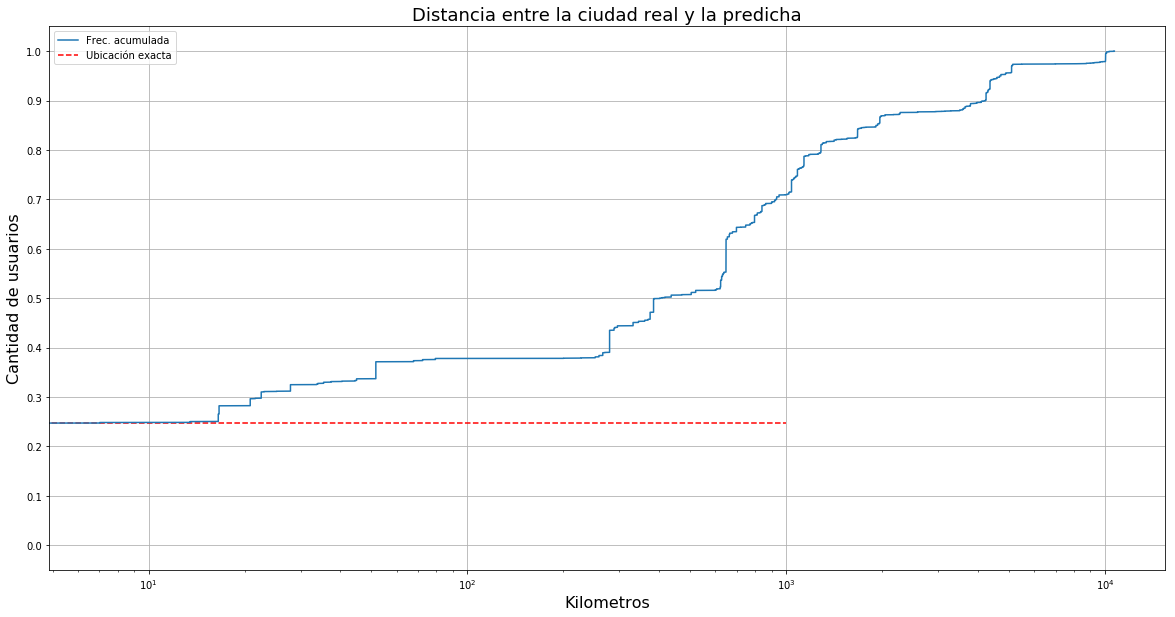

In [64]:
ecdf = ECDF(distances_predicted)

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("Kilometros", fontsize=16)
plt.ylabel("Cantidad de usuarios", fontsize=16)
plt.title("Distancia entre la ciudad real y la predicha", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.1))
#plt.x
#plt.xticks(np.arange(0,1000,50))
plt.xscale('log')
plt.hlines(accuracy_score(y_test, y_predicted), -200, 1000, colors='r', linestyles='dashed')
plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

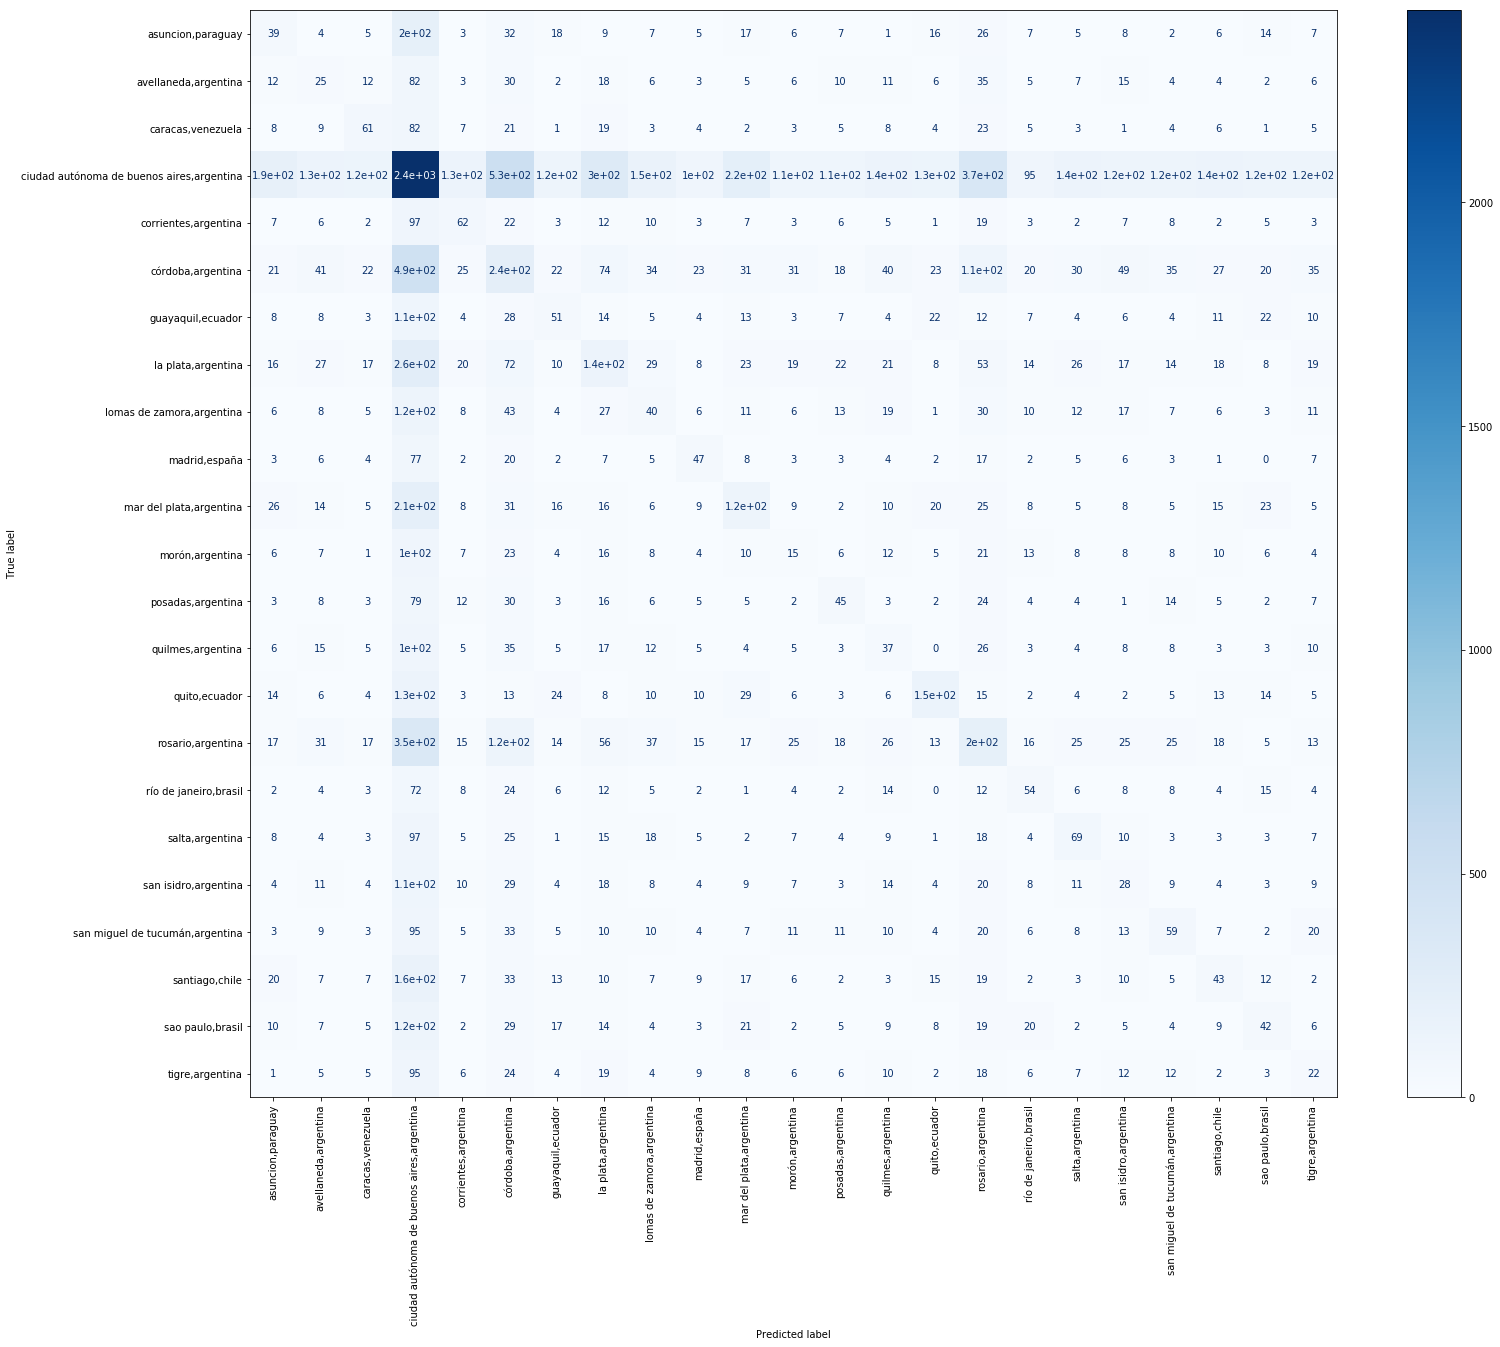

In [65]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 20)
disp = plot_confusion_matrix(grid_drop.best_estimator_, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None,
                                xticks_rotation='vertical',
                            ax=ax)

SVM

In [66]:
X_train_scaled = scale(X_train, with_mean=False)
X_test_scaled = scale(X_test, with_mean=False)

In [67]:
svc = SVC()

param_grid= {'class_weight': ['balanced'], 'cache_size': [2000.0]}

grid_drop = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
grid_drop.fit(X_train_scaled, y_train)
print(grid_drop.best_params_, grid_drop.best_score_)

{'cache_size': 2000.0, 'class_weight': 'balanced'} 0.19855277482080846


In [68]:
y_predicted = grid_drop.predict(X_test_scaled)

In [69]:
accuracy_score(y_test, y_predicted)

0.21035120147874306

In [70]:
balanced_accuracy_score(y_test, y_predicted)

0.19372773266201718

In [71]:
distances_predicted = get_difference_distance(
    y_predicted,
    y_test
)

Total NaN:  0


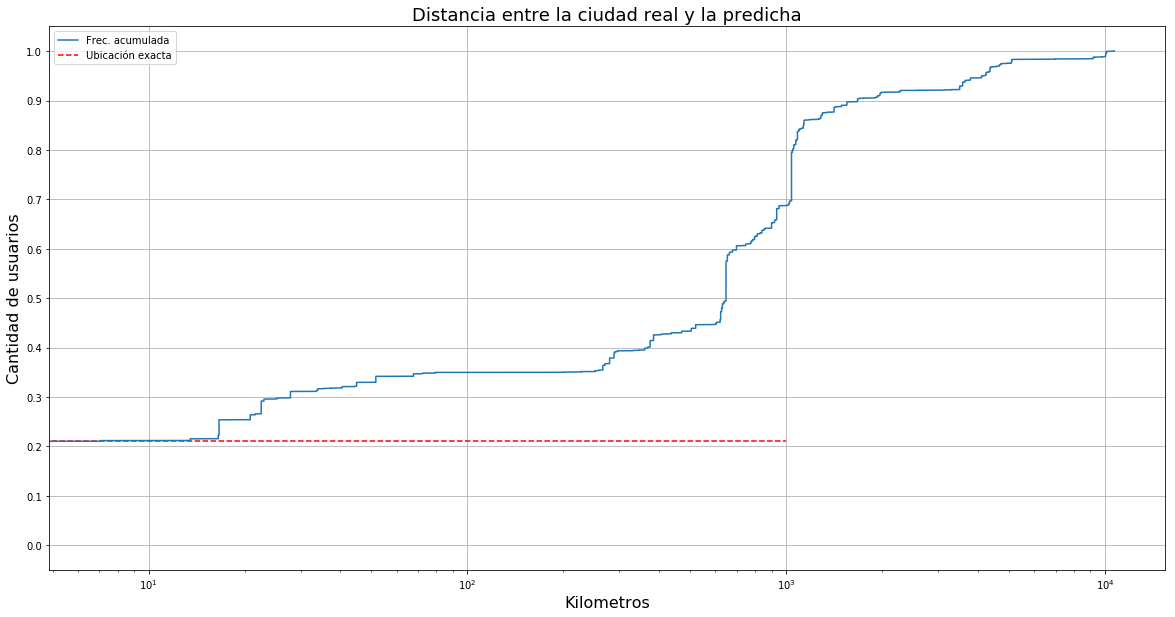

In [72]:
ecdf = ECDF(distances_predicted)

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("Kilometros", fontsize=16)
plt.ylabel("Cantidad de usuarios", fontsize=16)
plt.title("Distancia entre la ciudad real y la predicha", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.1))
#plt.x
#plt.xticks(np.arange(0,1000,50))
plt.xscale('log')
plt.hlines(accuracy_score(y_test, y_predicted), -200, 1000, colors='r', linestyles='dashed')
plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

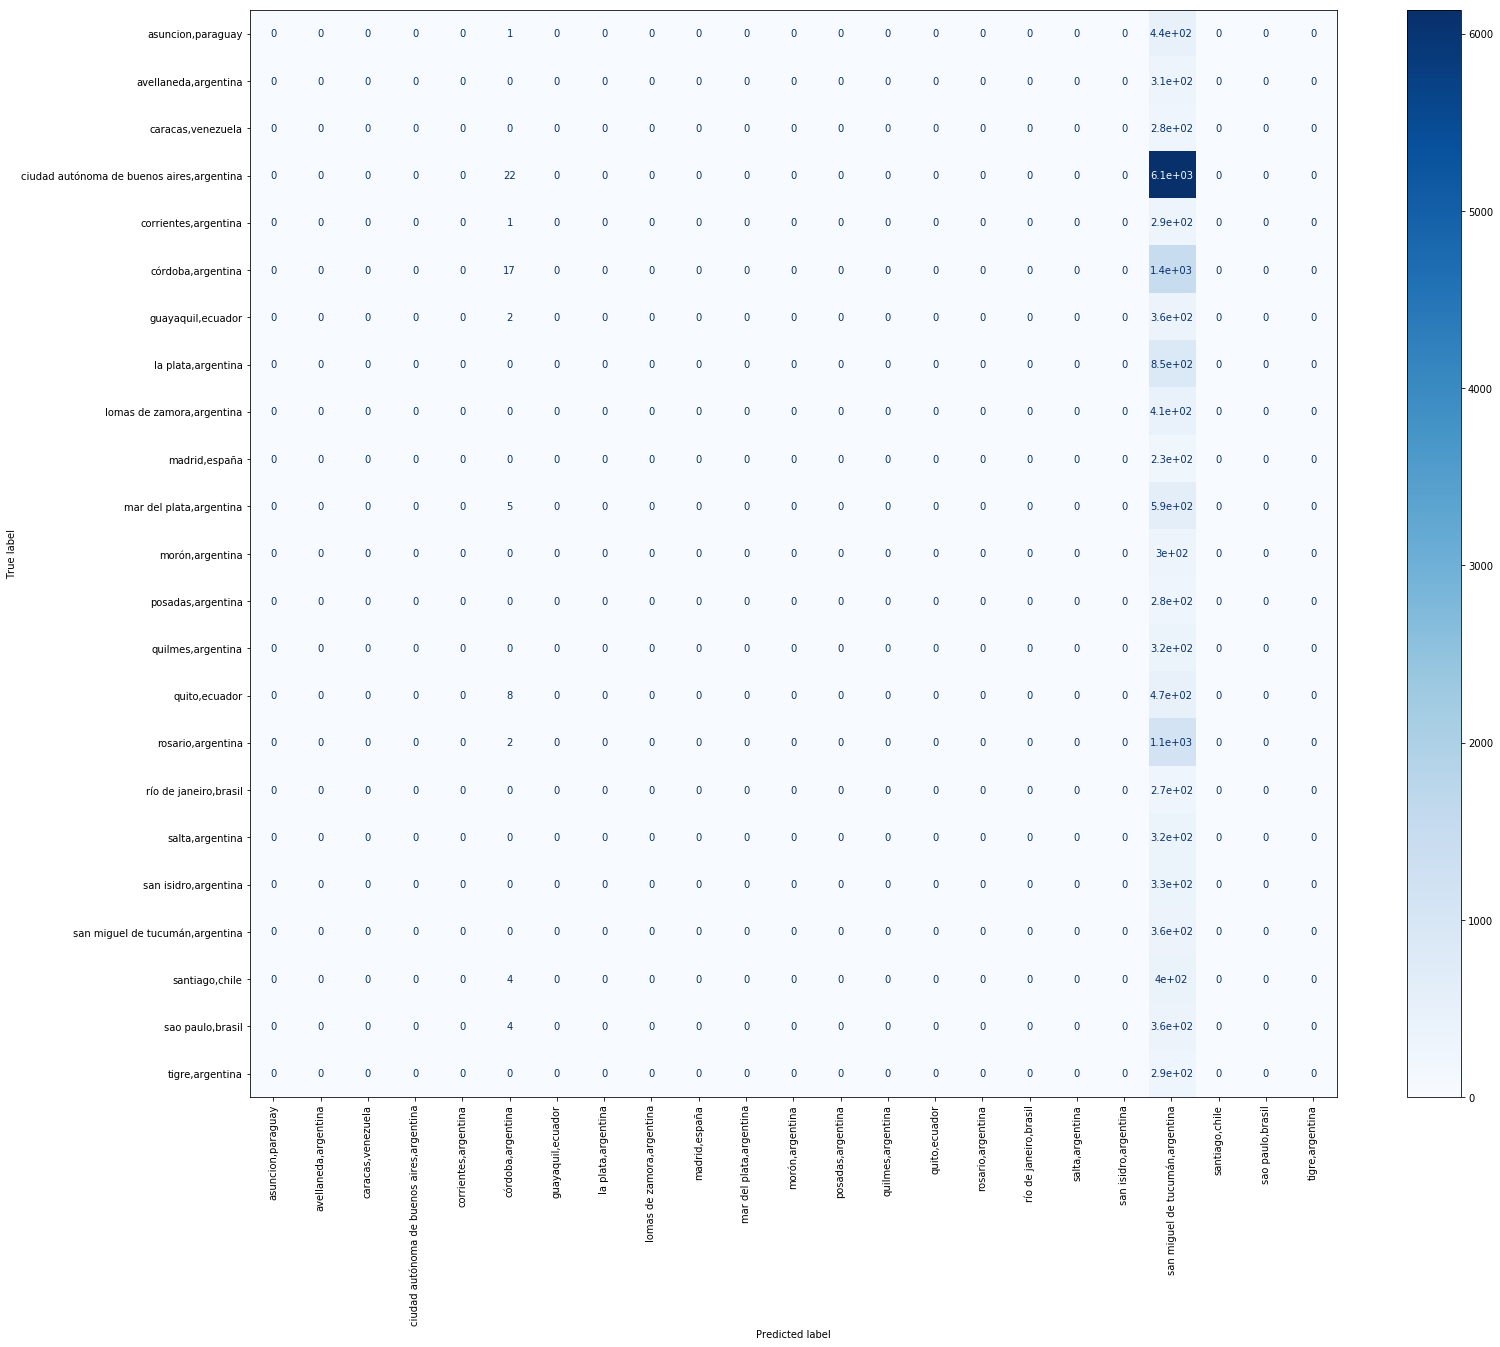

In [73]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 20)
disp = plot_confusion_matrix(grid_drop.best_estimator_, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None,
                                xticks_rotation='vertical',
                            ax=ax)

# Usando co-menciones y node2vec con pesos

In [74]:
vector_of_co_mentions = vector_of_mentions.dot(vector_of_mentions.T)
vector_of_co_mentions.setdiag(0, k=0)

/var/home/ffunes/venv/lib/python3.5/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [75]:
vector_of_co_mentions

<54099x54099 sparse matrix of type '<class 'numpy.longlong'>'
	with 55842861 stored elements in Compressed Sparse Row format>

In [76]:
cx = vector_of_co_mentions.tocoo()
edges = []
for i,j,v in zip(cx.row, cx.col, cx.data):
    format_str = str(i) + " " + str(j) + " " + str(v)
    edges.append(format_str)

In [77]:
len(edges)

55842861

In [78]:
df = pd.DataFrame({"edges": edges})
df.to_csv("../edges_comentions.csv", header=False, index=False)

In [53]:
!cd ../snap/examples/node2vec && \
./node2vec -i:../../../edges_comentions.csv -o:../../../edges_comentions_node2vec.emb -d:16 -p:0.25 -q:0.25 -l:3 -r:10 -dr -w


An algorithmic framework for representational learning on graphs. [Apr 21 2020]
Input graph path (-i:)=../../../edges_comentions.csv
Output graph path (-o:)=../../../edges_comentions_node2vec.emb
Number of dimensions. Default is 128 (-d:)=16
Length of walk per source. Default is 80 (-l:)=3
Number of walks per source. Default is 10 (-r:)=10
Context size for optimization. Default is 10 (-k:)=10
Number of epochs in SGD. Default is 1 (-e:)=1
Return hyperparameter. Default is 1 (-p:)=0.25
Inout hyperparameter. Default is 1 (-q:)=0.25
Verbose output. (-v)=NO
Graph is directed. (-dr)=YES
Graph is weighted. (-w)=YES
Output random walks instead of embeddings. (-ow)=NO
Terminated


In [80]:
vector_of_co_mentions_node2vec = pd.read_csv("../edges_comentions_node2vec.emb", header=None, skiprows=1, sep=" ")
vector_of_co_mentions_node2vec.drop(range(vector_of_mentions.shape[0], vector_of_mentions.shape[1]), inplace=True)
vector_of_co_mentions_node2vec.drop(0, axis=1, inplace=True)
vector_of_co_mentions_node2vec.shape

FileNotFoundError: [Errno 2] File b'../edges_comentions_node2vec.emb' does not exist: b'../edges_comentions_node2vec.emb'

In [ ]:
vector = hstack([vector_of_hashtags, vector_of_hashtags_countries, vector_of_co_mentions_node2vec.values])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(vector, users_complete_location[:,0], test_size=0.30)

In [ ]:
decisiontree = DecisionTreeClassifier()
decisiontree.get_params()

In [ ]:
param_grid= {'max_features': [10, 20, 50, 'auto', 1000, 2000,None], 'max_depth': [8, 80, 200, 500, None], 'min_samples_leaf': [1],
             'class_weight': ['balanced']}#, 'min_samples_split': [2500]}
grid_drop = GridSearchCV(decisiontree, param_grid, cv=5, scoring='accuracy')
grid_drop.fit(X_train, y_train)
print(grid_drop.best_params_, grid_drop.best_score_)

In [ ]:
y_predicted = grid_drop.predict(X_test)

In [ ]:
accuracy_score(y_test, y_predicted)

In [ ]:
balanced_accuracy_score(y_test, y_predicted)

In [ ]:
distances_predicted = get_difference_distance(
    y_predicted,
    y_test
)

In [ ]:
ecdf = ECDF(distances_predicted)

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("Kilometros", fontsize=16)
plt.ylabel("Cantidad de usuarios", fontsize=16)
plt.title("Distancia entre la ciudad real y la predicha", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.1))
#plt.x
#plt.xticks(np.arange(0,1000,50))
plt.xscale('log')
plt.hlines(accuracy_score(y_test, y_predicted), -200, 1000, colors='r', linestyles='dashed')
plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 20)
disp = plot_confusion_matrix(grid_drop.best_estimator_, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None,
                                xticks_rotation='vertical',
                            ax=ax)

SVM

In [ ]:
X_train_scaled = scale(X_train, with_mean=False)
X_test_scaled = scale(X_test, with_mean=False)

In [ ]:
svc = SVC()

param_grid= {'class_weight': ['balanced'], 'cache_size': [2000.0]}

grid_drop = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
grid_drop.fit(X_train_scaled, y_train)
print(grid_drop.best_params_, grid_drop.best_score_)

In [ ]:
y_predicted = grid_drop.predict(X_test_scaled)

In [ ]:
accuracy_score(y_test, y_predicted)

In [ ]:
balanced_accuracy_score(y_test, y_predicted)

In [ ]:
distances_predicted = get_difference_distance(
    y_predicted,
    y_test
)

In [ ]:
ecdf = ECDF(distances_predicted)

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("Kilometros", fontsize=16)
plt.ylabel("Cantidad de usuarios", fontsize=16)
plt.title("Distancia entre la ciudad real y la predicha", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.1))
#plt.x
#plt.xticks(np.arange(0,1000,50))
plt.xscale('log')
plt.hlines(accuracy_score(y_test, y_predicted), -200, 1000, colors='r', linestyles='dashed')
plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 20)
disp = plot_confusion_matrix(grid_drop.best_estimator_, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None,
                                xticks_rotation='vertical',
                            ax=ax)

# Hashtags y menciones - generando muestras aleatorias

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(vector, users_complete_location[:,0], test_size=0.30)

In [ ]:
samples = dict(pd.DataFrame({'r':y_train})['r'].value_counts())
samples

In [ ]:
(values,counts) = np.unique(y_train,return_counts=True)
ind=np.argmax(counts)
mayority_sample_city = values[ind]
mayority_samples = counts[ind]

In [ ]:
smote_undersample_dict = samples.copy()
smote_undersample_dict[mayority_sample_city] = int(mayority_samples * 0.5)
smote_undersample_dict

In [ ]:
undersample = RandomUnderSampler(sampling_strategy=smote_undersample_dict)
X_train, y_train = undersample.fit_resample(X_train, y_train)

In [ ]:
(values,counts) = np.unique(y_train,return_counts=True)
ind=np.argmax(counts)
mayority_sample_city = values[ind]
mayority_samples = counts[ind]
print(mayority_sample_city, mayority_samples)

In [ ]:
smote_oversample_dict = dict(map(lambda x: [x[1], int(mayority_samples * 1.0)], np.ndenumerate(y_train)))

In [ ]:
del smote_oversample_dict[mayority_sample_city]

In [ ]:
smote_oversample_dict

In [ ]:
oversample = SMOTE(sampling_strategy=smote_oversample_dict)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [ ]:
pd.DataFrame({'r':y_train})['r'].value_counts()

DecisionTree

In [ ]:
decisiontree = DecisionTreeClassifier()
decisiontree.get_params()

In [ ]:
param_grid= {'max_features': [10, 20, 50, 'auto', 1000, 2000,None], 'max_depth': [8, 80, 200, 500, None], 'min_samples_leaf': [1],
             'class_weight': [None], 'min_impurity_decrease': [0.01, 0.001, 0.0001,  0.00001, 0.000001]}#, 'min_samples_split': [2500]}
grid_drop = GridSearchCV(decisiontree, param_grid, cv=5, scoring='accuracy')
grid_drop.fit(X_train, y_train)
print(grid_drop.best_params_, grid_drop.best_score_)

In [ ]:
y_predicted = grid_drop.predict(X_test)

In [ ]:
accuracy_score(y_test, y_predicted)

In [ ]:
distances_predicted = get_difference_distance(
    y_predicted,
    y_test
)

In [ ]:
ecdf = ECDF(distances_predicted)

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("Kilometros", fontsize=16)
plt.ylabel("Cantidad de usuarios", fontsize=16)
plt.title("Distancia entre la ciudad real y la predicha", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.1))
#plt.x
#plt.xticks(np.arange(0,1000,50))
plt.xscale('log')
plt.hlines(accuracy_score(y_test, y_predicted), -200, 1000, colors='r', linestyles='dashed')
plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 20)
disp = plot_confusion_matrix(grid_drop.best_estimator_, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None,
                                xticks_rotation='vertical',
                            ax=ax)